<a href="https://colab.research.google.com/github/Stepka/Mark-Guesser-Text-Embeding-by-Universal-Sentence-Encoder-and-DNNRegressor/blob/master/Mark_Guesser_(Text_Embeding_by_Universal_Sentence_Encoder_and_DNNRegressor).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Playground
# This notebook is playground for text semantic extraction task and then guess the mark based on extracted semantic.
# As input model have sentences with answer gived by person 
# and as output model should guess the mark from 0 to 5 (continious)
# that evaluate that answer. For training data marks evaluated by experts.
# 
# Model using Text Embeding by Universal Sentence Encoder and DNNRegressor for matching embeds to marks.

In [1]:
# Install the latest Tensorflow version.
!pip3 install --quiet tensorflow==1.13.1
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn
!pip show tensorflow

    100% |████████████████████████████████| 92.5MB 328kB/s 
    100% |████████████████████████████████| 3.2MB 11.3MB/s 
Name: tensorflow
Version: 1.13.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: grpcio, astor, tensorboard, keras-applications, wheel, six, numpy, termcolor, keras-preprocessing, protobuf, absl-py, tensorflow-estimator, gast
Required-by: stable-baselines, magenta, fancyimpute


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from tensorflow import keras
import math

W0319 08:20:22.912319 140077348525952 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [3]:
print(tf.__version__)
tf.executing_eagerly()

1.13.1


False

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
default_path = "/content/drive/My Drive/Colab Notebooks/Mark Guesser"

In [6]:
!ls '{default_path}'

 data  'Mark Guesser'


In [7]:
# train_data = load_csv_dataset(default_path + "/data/siop_ml_train_participant.csv")
source_data = pd.read_csv(default_path + "/data/siop_ml_train_participant.csv")

all_data = pd.concat([source_data['open_ended_1'], source_data['E_Scale_score']], axis=1, keys=['answer_1', 'mark_1'])

# all_data['mark_1'] = all_data['mark_1'].apply(lambda x: math.ceil(x) - 2)

print("Num rows: {}\n".format(len(all_data.index)))
train_data = all_data[:900]
test_data = all_data[900:]

print("train data: ", len(train_data.index))
train_data.head()
print("test data: ", len(test_data.index))
test_data.head()


Num rows: 1088

train data:  900
test data:  188


,answer_1,mark_1
900,I would also not be willing to change my plans...,3.750000
901,I would change my dates if it was reasonable t...,2.750000
902,I would probably go ahead and let my coworker ...,3.166667
903,I would verify that my vacation plans and date...,4.083333
904,I would change my vacation if I didn't have an...,3.500000


In [0]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_data, train_data["mark_1"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_data, train_data["mark_1"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_data, test_data["mark_1"], shuffle=False)

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3", "https://tfhub.dev/google/nnlm-en-dim128/1"]

In [0]:
embedded_text_feature_column = hub.text_embedding_column(
    key="answer_1", 
    module_spec=module_url)

In [11]:
estimator = tf.estimator.DNNRegressor(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    loss_reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE, 
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

INFO:tensorflow:Using default config.


I0319 08:20:40.409373 140077348525952 estimator.py:1739] Using default config.


W0319 08:20:40.418064 140077348525952 estimator.py:1760] Using temporary folder as model directory: /tmp/tmp9ob2er9l


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9ob2er9l', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f661119ce10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0319 08:20:40.423249 140077348525952 estimator.py:201] Using config: {'_model_dir': '/tmp/tmp9ob2er9l', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f661119ce10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
estimator.train(input_fn=train_input_fn, steps=500);

Instructions for updating:
Colocations handled automatically by placer.


W0319 08:20:40.455470 140077348525952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0319 08:20:40.479631 140077348525952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0319 08:20:40.484805 140077348525952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_functions.py:500: add_queue_runner (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Calling model_fn.


I0319 08:20:40.502076 140077348525952 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0319 08:20:41.577386 140077348525952 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0319 08:20:43.258284 140077348525952 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.cast instead.


W0319 08:20:43.546135 140077348525952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_estimator/python/estimator/canned/head.py:436: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Done calling model_fn.


I0319 08:20:43.710825 140077348525952 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0319 08:20:43.713872 140077348525952 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0319 08:20:46.005922 140077348525952 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0319 08:20:47.224837 140077348525952 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0319 08:20:48.021974 140077348525952 session_manager.py:493] Done running local_init_op.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0319 08:20:48.240483 140077348525952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/monitored_session.py:809: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp9ob2er9l/model.ckpt.


I0319 08:20:57.143417 140077348525952 basic_session_run_hooks.py:594] Saving checkpoints for 0 into /tmp/tmp9ob2er9l/model.ckpt.


INFO:tensorflow:loss = 11.885994, step = 1


I0319 08:21:16.920025 140077348525952 basic_session_run_hooks.py:249] loss = 11.885994, step = 1


INFO:tensorflow:Saving checkpoints for 47 into /tmp/tmp9ob2er9l/model.ckpt.


I0319 08:31:12.439248 140077348525952 basic_session_run_hooks.py:594] Saving checkpoints for 47 into /tmp/tmp9ob2er9l/model.ckpt.


INFO:tensorflow:Saving checkpoints for 93 into /tmp/tmp9ob2er9l/model.ckpt.


I0319 08:41:13.006951 140077348525952 basic_session_run_hooks.py:594] Saving checkpoints for 93 into /tmp/tmp9ob2er9l/model.ckpt.


INFO:tensorflow:global_step/sec: 0.0767876


I0319 08:42:59.213879 140077348525952 basic_session_run_hooks.py:680] global_step/sec: 0.0767876


INFO:tensorflow:loss = 0.65570086, step = 101 (1302.300 sec)


I0319 08:42:59.219556 140077348525952 basic_session_run_hooks.py:247] loss = 0.65570086, step = 101 (1302.300 sec)


INFO:tensorflow:Saving checkpoints for 142 into /tmp/tmp9ob2er9l/model.ckpt.


I0319 08:51:16.337022 140077348525952 basic_session_run_hooks.py:594] Saving checkpoints for 142 into /tmp/tmp9ob2er9l/model.ckpt.


INFO:tensorflow:Saving checkpoints for 194 into /tmp/tmp9ob2er9l/model.ckpt.


I0319 09:01:25.092648 140077348525952 basic_session_run_hooks.py:594] Saving checkpoints for 194 into /tmp/tmp9ob2er9l/model.ckpt.


INFO:tensorflow:global_step/sec: 0.0837316


I0319 09:02:53.506051 140077348525952 basic_session_run_hooks.py:680] global_step/sec: 0.0837316


INFO:tensorflow:loss = 0.61932576, step = 201 (1194.290 sec)


I0319 09:02:53.509778 140077348525952 basic_session_run_hooks.py:247] loss = 0.61932576, step = 201 (1194.290 sec)


INFO:tensorflow:Saving checkpoints for 246 into /tmp/tmp9ob2er9l/model.ckpt.


I0319 09:11:32.988241 140077348525952 basic_session_run_hooks.py:594] Saving checkpoints for 246 into /tmp/tmp9ob2er9l/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


W0319 09:11:37.501604 140077348525952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:966: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Saving checkpoints for 298 into /tmp/tmp9ob2er9l/model.ckpt.


I0319 09:21:34.983962 140077348525952 basic_session_run_hooks.py:594] Saving checkpoints for 298 into /tmp/tmp9ob2er9l/model.ckpt.


INFO:tensorflow:global_step/sec: 0.0860114


I0319 09:22:16.142098 140077348525952 basic_session_run_hooks.py:680] global_step/sec: 0.0860114


INFO:tensorflow:loss = 0.68584156, step = 301 (1162.641 sec)


I0319 09:22:16.150527 140077348525952 basic_session_run_hooks.py:247] loss = 0.68584156, step = 301 (1162.641 sec)


INFO:tensorflow:Saving checkpoints for 350 into /tmp/tmp9ob2er9l/model.ckpt.


I0319 09:31:39.601655 140077348525952 basic_session_run_hooks.py:594] Saving checkpoints for 350 into /tmp/tmp9ob2er9l/model.ckpt.


INFO:tensorflow:global_step/sec: 0.0872384


I0319 09:41:22.426438 140077348525952 basic_session_run_hooks.py:680] global_step/sec: 0.0872384


INFO:tensorflow:loss = 0.58002716, step = 401 (1146.280 sec)


I0319 09:41:22.430664 140077348525952 basic_session_run_hooks.py:247] loss = 0.58002716, step = 401 (1146.280 sec)


INFO:tensorflow:Saving checkpoints for 403 into /tmp/tmp9ob2er9l/model.ckpt.


I0319 09:41:45.173338 140077348525952 basic_session_run_hooks.py:594] Saving checkpoints for 403 into /tmp/tmp9ob2er9l/model.ckpt.


INFO:tensorflow:Saving checkpoints for 456 into /tmp/tmp9ob2er9l/model.ckpt.


I0319 09:51:47.730243 140077348525952 basic_session_run_hooks.py:594] Saving checkpoints for 456 into /tmp/tmp9ob2er9l/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmp9ob2er9l/model.ckpt.


I0319 10:00:09.391610 140077348525952 basic_session_run_hooks.py:594] Saving checkpoints for 500 into /tmp/tmp9ob2er9l/model.ckpt.


INFO:tensorflow:Loss for final step: 0.5834537.


I0319 10:00:16.059133 140077348525952 estimator.py:359] Loss for final step: 0.5834537.


In [0]:
def mean_absolute_error(labels, predictions):
    return {'mean_absolute_error': tf.metrics.mean_absolute_error(labels, predictions['predictions'])}

In [14]:
# estimator = tf.estimator.add_metrics(estimator, mean_absolute_error)

train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print(train_eval_result)
print(test_eval_result)



# print("Training set accuracy: {accuracy}".format(**train_eval_result))
# print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.


I0319 10:00:16.136332 140077348525952 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0319 10:00:17.354286 140077348525952 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0319 10:00:18.923607 140077348525952 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0319 10:00:19.349602 140077348525952 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-03-19T10:00:19Z


I0319 10:00:19.381425 140077348525952 evaluation.py:257] Starting evaluation at 2019-03-19T10:00:19Z


INFO:tensorflow:Graph was finalized.


I0319 10:00:19.752772 140077348525952 monitored_session.py:222] Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0319 10:00:19.756169 140077348525952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /tmp/tmp9ob2er9l/model.ckpt-500


I0319 10:00:19.768980 140077348525952 saver.py:1270] Restoring parameters from /tmp/tmp9ob2er9l/model.ckpt-500


INFO:tensorflow:Running local_init_op.


I0319 10:00:20.804058 140077348525952 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0319 10:00:21.524446 140077348525952 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-03-19-10:01:44


I0319 10:01:44.483660 140077348525952 evaluation.py:277] Finished evaluation at 2019-03-19-10:01:44


INFO:tensorflow:Saving dict for global step 500: average_loss = 0.63508356, global_step = 500, label/mean = 3.4716666, loss = 0.7442509, prediction/mean = 3.4633577


I0319 10:01:44.487482 140077348525952 estimator.py:1979] Saving dict for global step 500: average_loss = 0.63508356, global_step = 500, label/mean = 3.4716666, loss = 0.7442509, prediction/mean = 3.4633577


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /tmp/tmp9ob2er9l/model.ckpt-500


I0319 10:01:46.364408 140077348525952 estimator.py:2039] Saving 'checkpoint_path' summary for global step 500: /tmp/tmp9ob2er9l/model.ckpt-500


INFO:tensorflow:Calling model_fn.


I0319 10:01:46.401597 140077348525952 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0319 10:01:47.790529 140077348525952 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0319 10:01:49.467322 140077348525952 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0319 10:01:49.876279 140077348525952 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-03-19T10:01:49Z


I0319 10:01:49.904889 140077348525952 evaluation.py:257] Starting evaluation at 2019-03-19T10:01:49Z


INFO:tensorflow:Graph was finalized.


I0319 10:01:50.281545 140077348525952 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp9ob2er9l/model.ckpt-500


I0319 10:01:50.291640 140077348525952 saver.py:1270] Restoring parameters from /tmp/tmp9ob2er9l/model.ckpt-500


INFO:tensorflow:Running local_init_op.


I0319 10:01:51.342796 140077348525952 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0319 10:01:52.045337 140077348525952 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-03-19-10:02:09


I0319 10:02:09.931218 140077348525952 evaluation.py:277] Finished evaluation at 2019-03-19-10:02:09


INFO:tensorflow:Saving dict for global step 500: average_loss = 0.649312, global_step = 500, label/mean = 3.5496452, loss = 0.6288973, prediction/mean = 3.4157596


I0319 10:02:09.940209 140077348525952 estimator.py:1979] Saving dict for global step 500: average_loss = 0.649312, global_step = 500, label/mean = 3.5496452, loss = 0.6288973, prediction/mean = 3.4157596


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /tmp/tmp9ob2er9l/model.ckpt-500


I0319 10:02:09.946126 140077348525952 estimator.py:2039] Saving 'checkpoint_path' summary for global step 500: /tmp/tmp9ob2er9l/model.ckpt-500


{'average_loss': 0.63508356, 'label/mean': 3.4716666, 'loss': 0.7442509, 'prediction/mean': 3.4633577, 'global_step': 500}
{'average_loss': 0.649312, 'label/mean': 3.5496452, 'loss': 0.6288973, 'prediction/mean': 3.4157596, 'global_step': 500}


In [15]:
from collections import OrderedDict

predictions = estimator.predict(input_fn=predict_test_input_fn)

# print(list(predictions))


errors_sum = 0
ceiled_errors_sum = 0
pred_num = 0
matches_num = 0
error_threshold = 0.25

labels = test_data['mark_1'].values
predictions_data = []
error_data = []

dictionary = {}

for p in predictions:
  error_data.append(abs(labels[pred_num] - p['predictions'][0]))
  errors_sum += error_data[pred_num]
  ceiled_errors_sum += abs(math.ceil(labels[pred_num]) - math.ceil(p['predictions'][0]))
  predictions_data.append(p['predictions'][0])
  
  dictionary[pred_num] = labels[pred_num]
  
  if error_data[pred_num] <= error_threshold:
    matches_num += 1
    
  pred_num += 1
  
print(dictionary)
dictionary = OrderedDict(sorted(dictionary.items(), key=lambda kv: kv[1]))

print(dictionary)

print(dictionary.keys())
print(dictionary.values())

print(len(dictionary.keys()))
print(len(dictionary.values()))

sorted_labels = dictionary.values()
sorted_preds = []
for k, v in dictionary.items():
  sorted_preds.append(predictions_data[k])
  
  
print(sorted_labels)
print(sorted_preds)

print("Total: ", pred_num)
print("Errors sum: ", errors_sum)
print("Errors sum (ceiled): ", ceiled_errors_sum)
print("Matches: ", matches_num)
print("Avg error: ", (errors_sum / pred_num))
print("Accuracy: ", matches_num / pred_num)
print("Deviation percent: ", 1 - (errors_sum / pred_num) / 5)
print("Deviation percent (ceiled): ", 1 - (ceiled_errors_sum / pred_num) / 5)

# absolute = tf.metrics.mean_absolute_error(
#     test_data['mark_1'],
#     predictions
# )
# print(absolute)

INFO:tensorflow:Calling model_fn.


I0319 10:02:10.042228 140077348525952 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0319 10:02:11.297545 140077348525952 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0319 10:02:12.869143 140077348525952 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0319 10:02:13.134695 140077348525952 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0319 10:02:13.488722 140077348525952 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp9ob2er9l/model.ckpt-500


I0319 10:02:13.499416 140077348525952 saver.py:1270] Restoring parameters from /tmp/tmp9ob2er9l/model.ckpt-500


INFO:tensorflow:Running local_init_op.


I0319 10:02:14.502643 140077348525952 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0319 10:02:15.229325 140077348525952 session_manager.py:493] Done running local_init_op.


{0: 3.75, 1: 2.75, 2: 3.1666666667000003, 3: 4.0833333333, 4: 3.5, 5: 4.25, 6: 4.25, 7: 3.5833333332999997, 8: 4.3333333333, 9: 2.6666666667, 10: 4.0833333333, 11: 2.8333333332999997, 12: 4.0833333333, 13: 2.75, 14: 4.1666666667, 15: 4.0, 16: 1.8333333333000001, 17: 4.8333333333, 18: 3.4166666667000003, 19: 3.5833333332999997, 20: 3.5, 21: 2.0833333333, 22: 3.9166666667000003, 23: 1.4166666666999999, 24: 4.75, 25: 2.0, 26: 3.4166666667000003, 27: 3.4166666667000003, 28: 3.75, 29: 2.4166666667, 30: 3.0, 31: 2.6666666667, 32: 2.9166666667000003, 33: 4.3333333333, 34: 3.1666666667000003, 35: 4.3333333333, 36: 1.8333333333000001, 37: 4.8333333333, 38: 4.5833333333, 39: 3.25, 40: 1.4166666666999999, 41: 3.8333333332999997, 42: 3.0833333332999997, 43: 4.0, 44: 1.75, 45: 4.5, 46: 3.8333333332999997, 47: 3.5, 48: 4.75, 49: 4.25, 50: 3.9166666667000003, 51: 3.6666666667000003, 52: 3.25, 53: 3.4166666667000003, 54: 2.9166666667000003, 55: 4.0, 56: 2.25, 57: 3.6666666667000003, 58: 2.833333333299

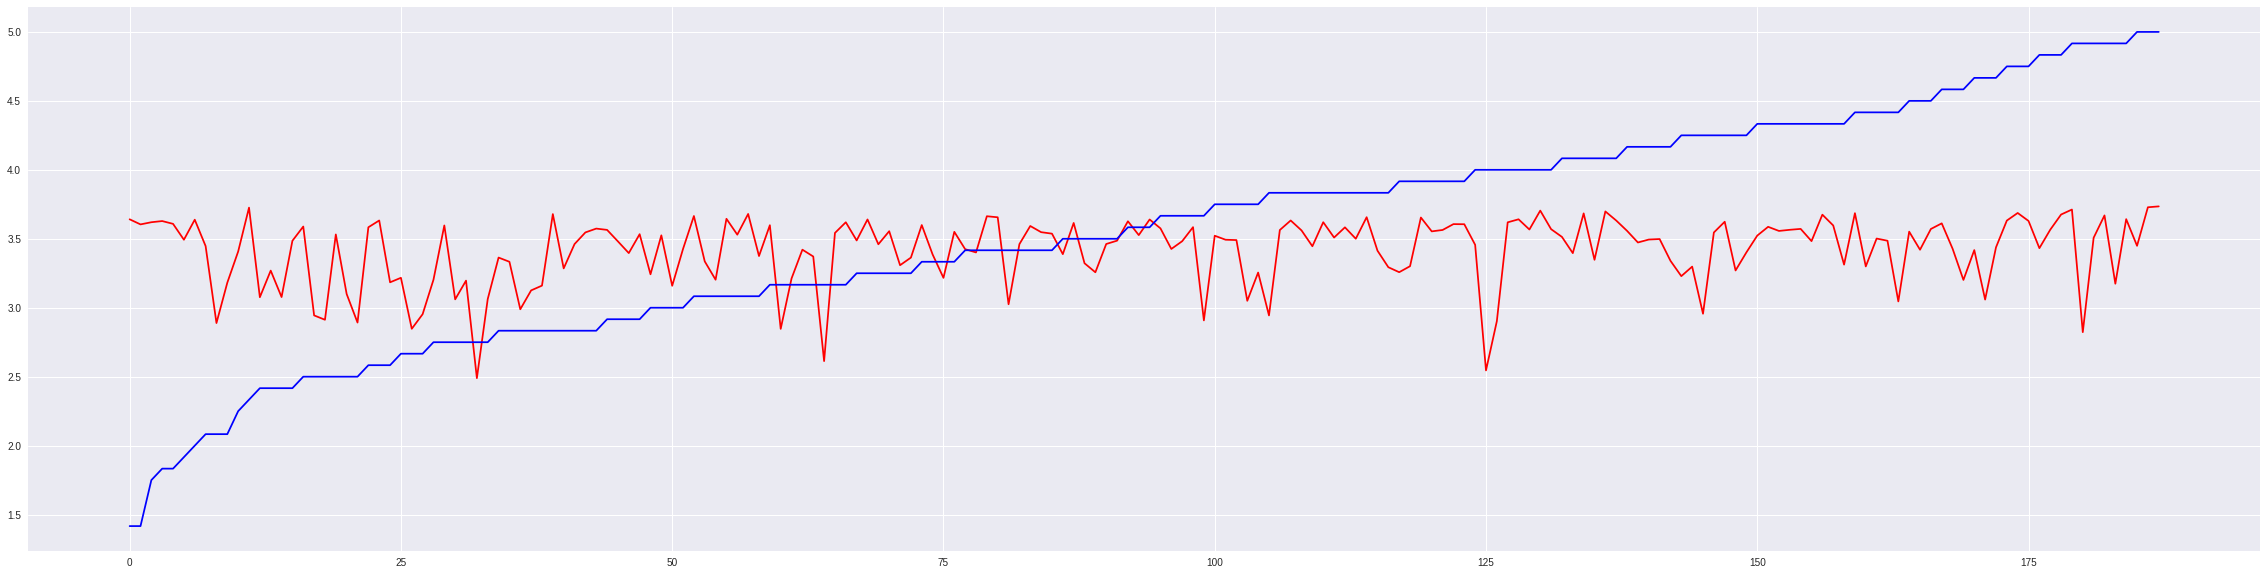

In [16]:
from numpy import *
import math
import matplotlib.pyplot as plt

xs = range(pred_num)

plt.figure(figsize=(40,10))
plt.plot(xs, sorted_preds, 'r') # plotting t, a separately 
plt.plot(xs, sorted_labels, 'b') # plotting t, b separately 
plt.show()

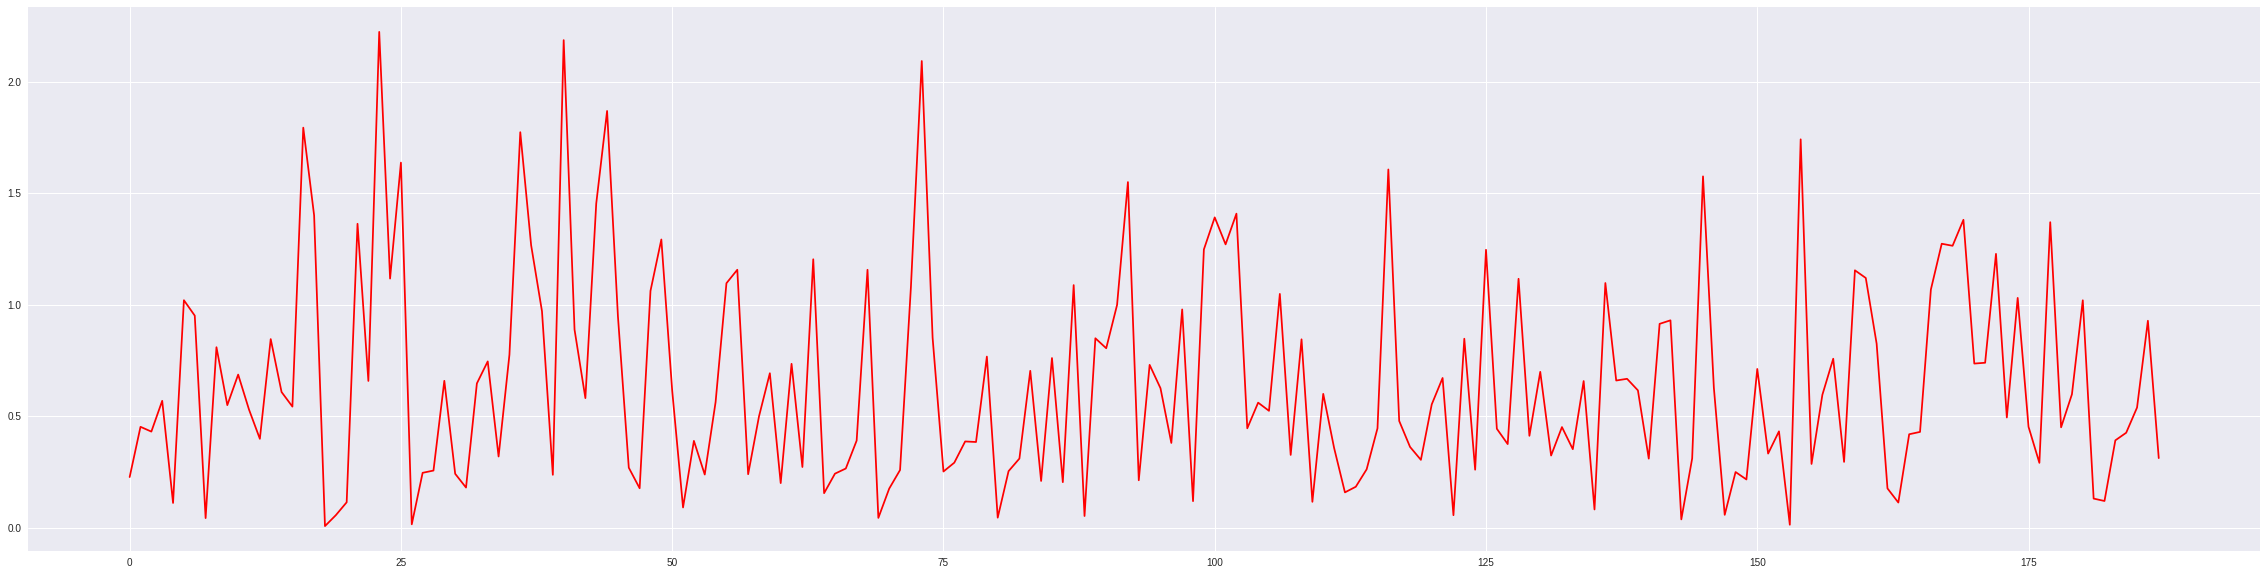

In [17]:
plt.figure(figsize=(40,10))
plt.plot(xs, error_data, 'r') # plotting t, b separately 
plt.show()

In [18]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "0", "1", "2", "3"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_data["mark_1"], 
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

INFO:tensorflow:Calling model_fn.


I0319 10:02:34.306023 140077348525952 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0319 10:02:35.121475 140077348525952 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0319 10:02:36.894220 140077348525952 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0319 10:02:37.172657 140077348525952 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0319 10:02:37.808671 140077348525952 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp9ob2er9l/model.ckpt-500


I0319 10:02:37.821950 140077348525952 saver.py:1270] Restoring parameters from /tmp/tmp9ob2er9l/model.ckpt-500


INFO:tensorflow:Running local_init_op.


I0319 10:02:38.836297 140077348525952 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0319 10:02:39.554756 140077348525952 session_manager.py:493] Done running local_init_op.


AssertionError: ignored

In [0]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Compute a representation for each message
messages = train_data["open_ended_1"].values

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

print("Messages  length: {}\n".format(len(messages)))

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message {}: {}".format(i, messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

In [0]:
def convert_marks_to_weighted_vectors(marks, dimension):
  weighted_vector = np.zeros(shape = (len(marks), dimension))
  for i, mark in enumerate(marks):
    mark_category_vector = weighted_vector[i]
    floor_mark = math.floor(mark)
    diff_mark = mark - floor_mark
    mark_category_vector[floor_mark] = 1 - diff_mark
    if(len(mark_category_vector) > floor_mark + 1):
      mark_category_vector[floor_mark + 1] = diff_mark
    
  return weighted_vector

In [0]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam

train_answers = message_embeddings[:900]
# train_marks = np.array([math.ceil(i * 10) for i in train_data["E_Scale_score"].values[:900]])
train_marks = train_data["E_Scale_score"].values[:900]
# train_marks_category_vector = keras.utils.to_categorical(train_marks, num_classes=6)
train_marks_category_vector = convert_marks_to_weighted_vectors(train_marks, 6)
    
test_answers = message_embeddings[900:]
# test_marks = np.array([math.ceil(i * 10) for i in train_data["E_Scale_score"].values[900:]])
test_marks = train_data["E_Scale_score"].values[900:]
# test_marks_category_vector = keras.utils.to_categorical(test_marks, num_classes=6)
test_marks_category_vector = convert_marks_to_weighted_vectors(test_marks, 6)

print(test_marks[92])
print(test_marks_category_vector[92])

model = Sequential()
model.add(Dense(6, activation='relu', input_dim=512))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001)
# hinge
# logcosh
# cosine_proximity
model.compile(loss='cosine_proximity',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(train_answers, train_marks_category_vector,
          epochs=5,
          batch_size=128)

test_loss, test_acc = model.evaluate(test_answers, test_marks_category_vector, batch_size=128)

print('Точность после проверки:', test_acc)

predictions = model.predict(test_answers)

from sklearn.preprocessing import normalize
import scipy

# norm = np.linalg.norm(predictions[0])
print(predictions[0])
summa = sum(predictions[0])
print(summa)
norm = [number/summa for number in predictions[0]]
print(test_marks[0])
print(test_marks_category_vector[0])
print(norm)

In [0]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  plot_similarity(messages_, message_embeddings_, 90)

In [0]:
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)